# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to GMM and SVD.

## Exercise 1 (25 points)

In this exercise we will implement 1-dimensional GMM clustering algorithm from scratch. A GMM distribution is composed of `k` components, each characterized by:

1. A mixture proportion
2. A mean for its Normal Distribution
3. A variance for its Normal Distribution

So, to generate a dataset that follows a GMM dsitrbution we need a list of those parameters. In this exercise we will use a class called `Component` to capture the parameters for a given component. And a GMM will be a list of `Component`s.

### Collaborators: Sarah Bonna, Shivangi

In [7]:
class Component:
    def __init__(self, mixture_prop, mean, variance):
        self.mixture_prop = mixture_prop
        self.mean = mean
        self.variance = variance

example_gmm = [Component(.5, 5, 1), Component(.5, 8, 1)]


a) Complete the function below to validate and generate a dataset following a GMM distribution, given a specified set of GMM parameters as above and a size. You may only use the methods already imported in the cell. (10pts)

In [18]:
from numpy.random import normal, uniform
def generate_gmm_dataset(gmm_params, size):
    if not is_valid_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        sample = normal(comp.mean, comp.variance)
        dataset.append(sample)
    return dataset

def is_valid_gmm(gmm_params):
    '''
        Checks that the sum of the mixture
        proportions is 1
    '''
    sum_props = sum([comp.mixture_prop for comp in gmm_params])
    return abs(sum_props - 1) < 1e-12

def get_random_component(gmm_params):
    '''
        returns component with prob
        proportional to mixture_prop
    '''
    r = uniform()
    total = 0
    for comp in gmm_params:
        total += comp.mixture_prop
        if r < total:
            return comp
    return gmm_params[-1]

# test your code: this should return a list of 10 numbers similar to worksheet 8
data = generate_gmm_dataset(example_gmm, 1000)

b) Finish the implementation below of the Expectation-Maximization Algorithm. Only use methods that have been imported in the cell. (15pts)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


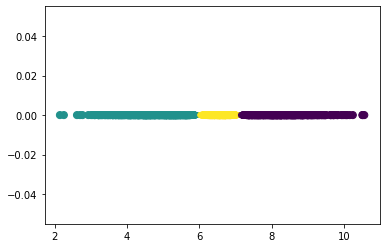

In [19]:
from scipy.stats import norm
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def gmm_init(k, dataset):
    kmeans = KMeans(k, init='k-means++').fit(X=array(dataset).reshape(-1, 1))
    gmm_params = []
    for i in range(k):
        prob = sum(kmeans.labels_ == i) / len(dataset)
        mean = kmeans.cluster_centers_[i][0]
        var = sum((dataset[j] - mean) ** 2 for j in range(len(dataset)) if kmeans.labels_[j] == i) / sum(kmeans.labels_ == i)
        gmm_params.append((prob, mean, var))
    return gmm_params


def compute_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j
    '''
    gmm_params = []
    for j in range(k):
        total = sum(probs[i][j] for i in range(len(dataset)))
        prob = total / len(dataset)
        mean = sum(probs[i][j] * dataset[i] for i in range(len(dataset))) / total
        var = sum(probs[i][j] * (dataset[i] - mean) ** 2 for i in range(len(dataset))) / total
        gmm_params.append((prob, mean, var))
    return gmm_params


def compute_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
    '''
    probs = []
    for x in dataset:
        p = [gmm_params[j][0] * norm.pdf(x, gmm_params[j][1], gmm_params[j][2]) for j in range(k)]
        p = [p[j] / sum(p) for j in range(k)]
        probs.append(p)
    return probs


def expectation_maximization(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_gmm(k, dataset, probs)

    return probs, gmm_params


# for testing: you should see smaller sized points
# near the boundary of a cluster if it is close to another cluster
probs, gmm_p = expectation_maximization(3, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2  # square to emphasize the difference
plt.scatter(data, [0.0 for _ in range(len(data))], c=labels, cmap='viridis', s=size)
plt.show()

Notes:

1. your code should work with any number of components, each with reasonable parameters.
2. your code should work for 1 to about 5 iterations of the EM algorithm. It may not work for iterations over 10 because the math we are doing may overflow and create `nans` - that's ok / don't worry about it.
3. worksheet 7 is your friend

## Exercise 2 (50 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (2.5 points)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

print(X)
print(y)
# your code here
df = pd.DataFrame(data=X, columns=[i for i in range(X.shape[1])])
df["y"] = y.astype(int)

# Save the DataFrame as a CSV file
df.to_csv("mnist_784.csv", index=False)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['5' '0' '4' ... '4' '5' '6']


b) Plot the singular value plot for a single example of the 0 digit (2.5 points)

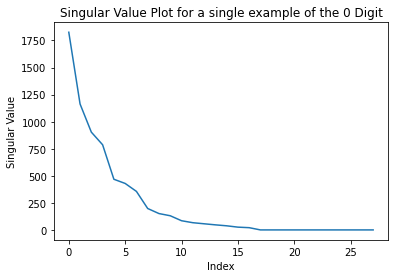

In [ ]:
from scipy.linalg import svd

example = df.loc[df["y"] == 0].iloc[0, :-1].values

# Perform SVD on the example
U, s, Vt = svd(example.reshape(28, 28))
#print(len(s))

# Plot the singular values
plt.plot(s)
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.title("Singular Value Plot for a single example of the 0 Digit")
plt.show()

c) Just like we did in class with the image of the boat: By setting some singular values to 0, plot the approximation of an image of a 0 digit next to the original image. (10 points)

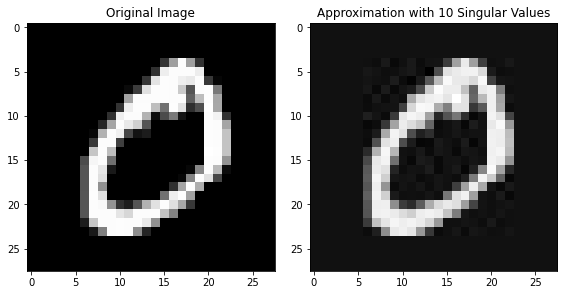

In [ ]:
import numpy as np
example = df.loc[df["y"] == 0].iloc[0, :-1].values

# Perform SVD on the example
U, s, Vt = svd(example.reshape(28, 28))

# Truncate the singular values by setting some of them to 0
k = 10
s[k:] = 0

# Reconstruct the image using the truncated SVD
approx = U.dot(np.diag(s)).dot(Vt)

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(example.reshape(28, 28), cmap="gray")
axes[0].set_title("Original Image")
axes[1].imshow(approx, cmap="gray")
axes[1].set_title(f"Approximation with {k} Singular Values")
plt.tight_layout()
plt.show()

d) Consider the entire dataset as a matrix. Perform SVD and explain why / how you chose a particular rank. Note: you may not be able to run this on the entire dataset in a reasonable amount of time so you may take a small random sample for this and the following questions. (5 points)

Text(0.5, 1.0, 'Singular values')

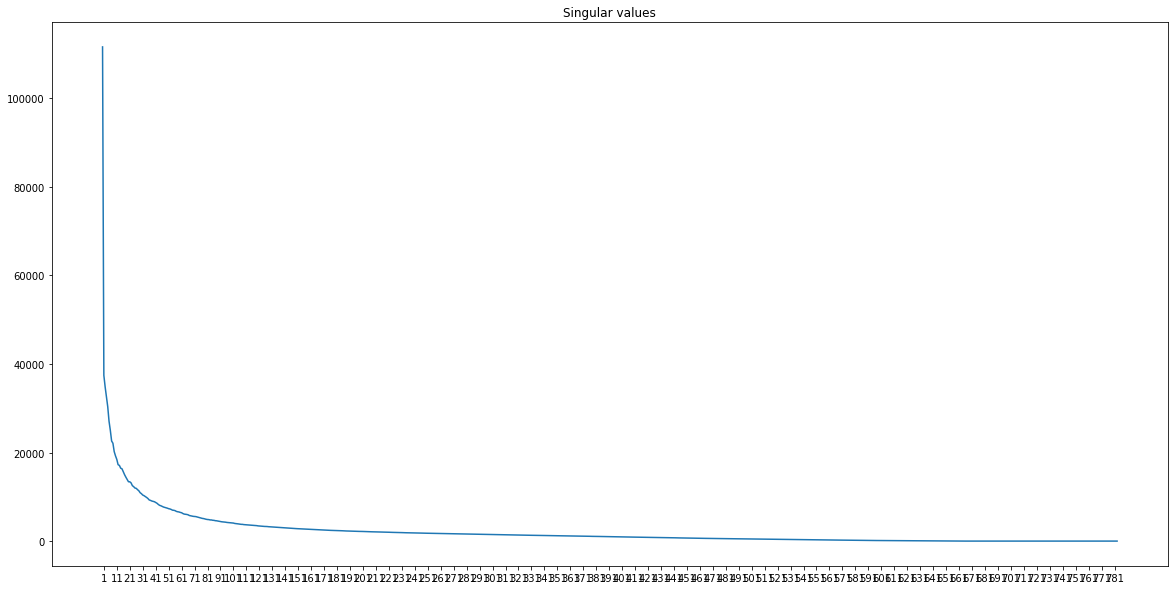

In [ ]:
sample_size = 5000
sample = df.sample(sample_size, random_state=42)
X = sample.iloc[:, :-1].values


U, s, Vt = svd(X, full_matrices=False)
xticks=[]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.xticks(np.arange(1, len(s)+1, step=10))
plt.plot(s)
plt.title("Singular values")

In [ ]:
rank = 7
U_rank = U[:, :rank]
s_rank = s[:rank]
Vt_rank = Vt[:rank, :]
X_approx = U_rank @ np.diag(s_rank) @ Vt_rank

Performing SVD on the sample dataset is one of the ways to choose a particular rank, for dimensionality reduction. The ‘elbow’ method consists of plotting a range of number of clusters on the x axis and the average within-cluster sum of squares in the y axis (as a measure of within cluster similarity between its elements). In this graph, we see that the optimal value of rank lies between 5-11(where the graph starts to curve). So, rank chose would be 7.

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. Note: the centroids should be represented as images. (10 points)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


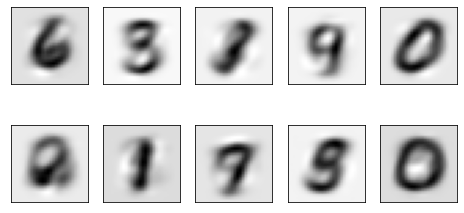

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_approx)
# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Plot the centroid of each cluster as an image
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(centroids[i].reshape(28, 28), cmap='binary')
    axi.set(xticks=[], yticks=[])
plt.show()

f) Repeat e) on the original dataset (if you used a subset of the dataset, keep using that same subset). Comment on any differences (or lack thereof) you observe between the centroids. (5 points)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


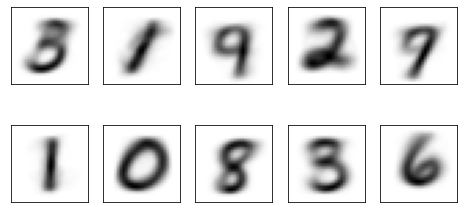

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Plot the centroid of each cluster as an image
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(centroids[i].reshape(28, 28), cmap='binary')
    axi.set(xticks=[], yticks=[])
plt.show()

Difference is observed as in the truncated dataset cluster centroids as they have multiple occurances of the same digit i.e digit 0, which means the data was not sufficient enough to distinguish between certain digits like how the 

g) Create a matrix (let's call it `O`) that is the difference between the original dataset and the rank-10 approximation of the dataset. (5 points)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=42)
X_reduced = svd.fit_transform(X)
X_approx = svd.inverse_transform(X_reduced)
O = X - X_approx

print(O)
print(O.shape)

[[ 1.12518289e-13  6.97806310e-14  6.22752826e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.06205464e-13  7.63178170e-14 -1.60359101e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.43209208e-13 -3.34175939e-15 -4.27173718e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 7.11298720e-15  1.06353336e-15 -1.50645182e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.49967375e-13 -1.46405920e-14  1.14917509e-15 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.10309912e-14 -5.22789679e-14 -5.16924542e-15 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
(5000, 784)


h) The largest (using euclidean distance from the origin) rows of the matrix `O` could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows of that matrix `O`. (10 points)

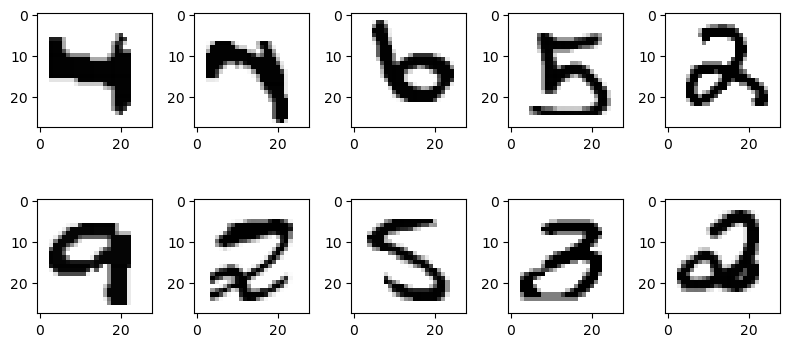

In [ ]:
row_norms = np.linalg.norm(O, axis=1)
largest_rows = row_norms.argsort()[-10:][::-1]

# Plot the 10 images responsible for the 10 largest rows of O
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4))
for i, ax in zip(largest_rows, axes.ravel()):
    ax.imshow(X[i].reshape(28, 28), cmap='binary')
plt.tight_layout()
plt.show()

The rows with the largest Euclidean distance from the origin represent data points that are farthest away from the centroid of the data distribution. Since we performed a rank-10 approximation, the first 10 rows could be considered as anomalies as they significantly deviate from the typical distribution of points.

## Exercise 3 (25pts)

For this question we will re-use the "mnist_784" dataset.

a) Begin by creating a training and testing datasest from our dataset, with a 80-20 ratio, and random_state=1. You can use the `train_test_split` function from sklearn. By holding out a portion of the dataset we can evaluate how our model generalizes to unseen data (i.e. data it did not learn from). **- 2 Points**

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv("mnist_784.csv")
X = df.iloc[:, :-1].values
y=df["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Print the shape of the training and testing sets
print("Shape of training set:", X_train.shape)
print("Shape of testing set:", X_test.shape)

Shape of training set: (56000, 784)
Shape of testing set: (14000, 784)


b) For K ranging from 1 to 20:

1. train a KNN on the training data - **2 points**
2. record the training and testing accuracy - **2 points**

Plot a graph of the training and testing set accuracy as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Briefly explain.  **- 4 points**

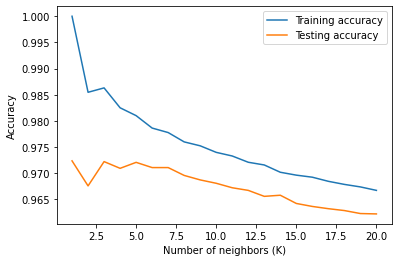

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
train_acc = []
test_acc = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

plt.plot(range(1, 21), train_acc, label='Training accuracy')
plt.plot(range(1, 21), test_acc, label='Testing accuracy')
plt.xlabel('Number of neighbors (K)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The optimal values for optimal k from the graph would be anywhere between 3-5 as there is a significant decrease with both the training and testing accuracy after that. K is chosen as 5

c) Using the best model from b), pick an image at random and plot it next to its K nearest neighbors (5pts)

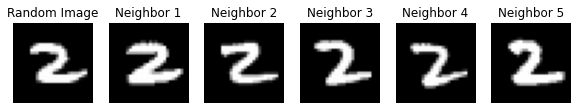

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

rand_idx = np.random.randint(len(X_test))
rand_img = X_test[rand_idx]

distances, indices = knn.kneighbors([rand_img])

plt.figure(figsize=(10,5))
plt.subplot(1, 6, 1)
plt.imshow(rand_img.reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Random Image')

for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(X_train[indices[0][i]].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title('Neighbor {}'.format(i+1))

plt.show()

d) Using a dimensionality reduction technique discussed in class, reduce the dimensionality of the dataset before applying a KNN model. Repeat b) and discuss similarities and differences to the previous model. Briefly discuss your choice of dimension and why you think the performance / accuracy of the model has changed. (10 points)

Text(0.5, 1.0, 'Singular values')

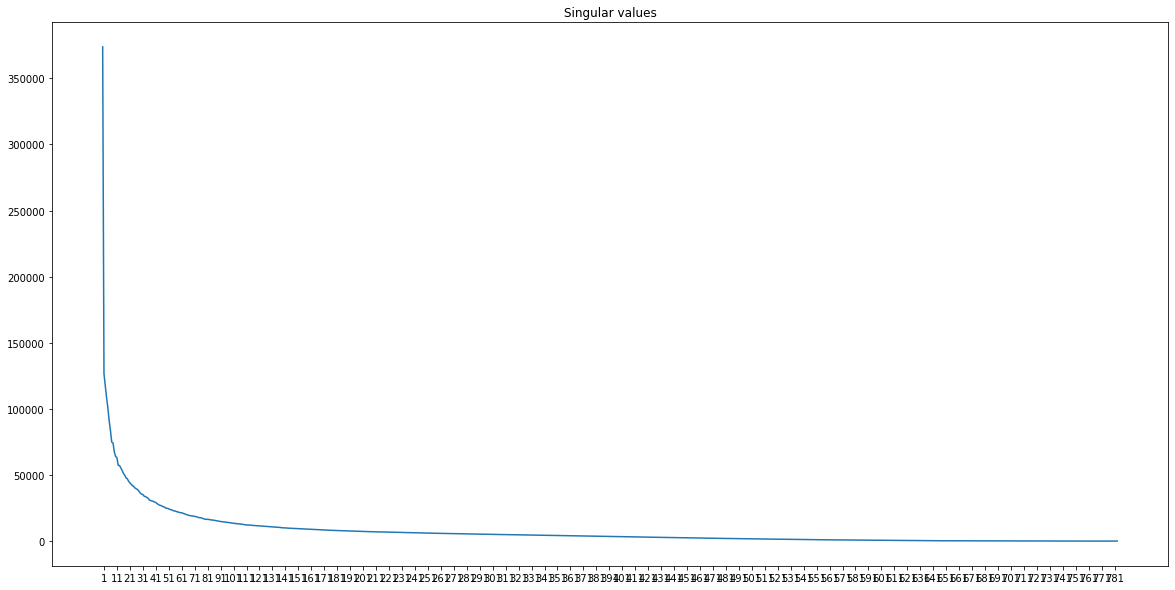

In [ ]:
U, s, Vt = svd(X_train, full_matrices=False)
xticks=[]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.xticks(np.arange(1, len(s)+1, step=10))
plt.plot(s)
plt.title("Singular values")

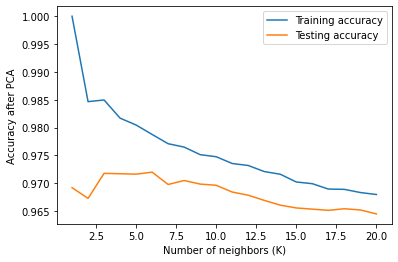

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

pca=PCA(n_components=20)

train_accs = []
test_accs = []
for k in range(1, 21):
    model = make_pipeline(pca, KNeighborsClassifier(n_neighbors=k))
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Plot the accuracy graph
plt.plot(range(1, 21), train_accs, label='Training accuracy')
plt.plot(range(1, 21), test_accs, label='Testing accuracy')
plt.xlabel('Number of neighbors (K)')
plt.ylabel('Accuracy after PCA')
plt.legend()
plt.show()

We see a slight difference in the accurcy after performing dimensionality reduction using svd and finding the range of optimal components between 17-25. The test accuracy after performing dimensionality reduction has a slightly lesser slop of decrease over K compared to the one without dimensionality reduction

## Bonus (20 points)

Complete the code below to support N-dimensional GMM clustering. Only use the methods imported below. Please take a look at the comments and docstrings for more info.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


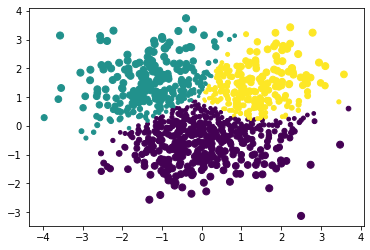

In [17]:
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from numpy.random import multivariate_normal as mv, uniform

nd_gmm = [
    Component(.25, [-1, 1], [[1, 0], [0, 1]]),
    Component(.50, [0, 0], [[1, 0], [0, 1]]),
    Component(.25, [1, 1], [[1, 0], [0, 1]])
]

def generate_nd_gmm_dataset(gmm_params, size):
    if not is_valid_nd_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        #print(comp.mean)
        #print(comp.variance)
        normal=multivariate_normal(mean=comp.mean, cov=comp.variance)
        dataset.append(normal.rvs())
    return array(dataset) # this should be a numpy array instead of a list


def is_valid_nd_gmm(gmm_params):
    '''
        Check that all the dimensions are consistent
        accross all components
    '''
    D = len(gmm_params[0].mean)
    for comp in gmm_params:
        if len(comp.mean) != D or array(comp.variance).shape != (D, D):
            return False
    return is_valid_gmm(gmm_params) # checks if mixture components add to 1

def gmm_nd_init(k, dataset):
    kmeans = KMeans(k, init='k-means++').fit(X=dataset)
    gmm_params = []
    for i in range(k):
        cluster_data = dataset[kmeans.labels_ == i]
        mean = cluster_data.mean(axis=0)
        covariance = array([uniform(-1, 1, size=dataset.shape[1]) for _ in range(dataset.shape[1])]) 
        covariance = covariance @ covariance.T # to ensure that covariance is PSD 
        mixture_prop = len(cluster_data) / len(dataset)
        gmm_params.append(Component(mixture_prop, mean, covariance))
    return gmm_params

def compute_nd_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j

        Here mean_j is a vector and var_j is a matrix
    '''
    N,D = dataset.shape
    gmm_params = []
    probs=array(probs)
    dataset=array(dataset)
    for j in range(k):
        mixture_prop = sum(probs[i][j] for i in range(N)) / N
        mean = sum(probs[i][j] * dataset[i] for i in range(N)) / sum(probs[i][j] for i in range(N))
        covariance = sum(probs[i][j] * (dataset[i] - mean).reshape(D, 1) @ (dataset[i] - mean).reshape(1, D) for i in range(N))
        # Dividing by the sum of probabilities ensures that the resulting covariance is positive definite which was an issue I ran into.
        covariance /= sum(probs[i][j] for i in range(N))
        gmm_params.append(Component(mixture_prop, mean, covariance))
    return gmm_params

def compute_nd_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
        
        Here x_i are vectors
    '''
    N, D = array(dataset).shape
    probs = [[0] * k for _ in range(N)]
    for i in range(N):
        for j in range(k):
          #mean = gmm_params[j].mean.flatten().reshape((-1, D))
          #print("mean:"+str(len(gmm_params[j].mean)))
          #print("var:"+str(len(gmm_params[j].variance)))
          probs[i][j] = gmm_params[j].mixture_prop * multivariate_normal.pdf(dataset[i], mean=gmm_params[j].mean, cov=gmm_params[j].variance)
        probs[i] = [prob / sum(probs[i]) for prob in probs[i]]
    return probs


def expectation_maximization_nd(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_nd_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_nd_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_nd_gmm(k, dataset, probs)

    return probs, gmm_params


data = generate_nd_gmm_dataset(nd_gmm, 1000)
probs, gmm_p = expectation_maximization_nd(3, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=size)
plt.show()